# EyeFeatures: From Gazes to Fixations

Process of extracting fixations from raw gazes determines all future characteristics of fixations and saccades, thus being quite important. This tutorial covers `eyetracking.preprocessing` module which offers algorithms to control this extraction and to make it as smooth as possible.

Let's load simple dataset with raw gazes.

In [1]:
import os
from os.path import join

import pandas as pd

import warnings
warnings.simplefilter("ignore")

In [2]:
def get_movies_dataset():
    """
    Read Movies Dataset from https://www.inb.uni-luebeck.de/index.php?id=515, static images.
    * gaze_x: x-coordinate of gaze.
    * gaze_y: y-coordinate of gaze.
    * timestamp: number of milliseconds from start of the recording.
    * film: name of movie.
    * frame: number of frame.
    * subject: person identifier.
    """
    df = pd.read_csv(join('data', 'movies_data.csv'), index_col=False)
    return df

In [3]:
data = get_movies_dataset()
data

,subject,film,frame,timestamp,gaze_x,gaze_y
0,V10,holsten_gate,0,3.667,0.499219,0.501482
1,V10,holsten_gate,0,7.581,0.499219,0.502962
2,V10,holsten_gate,0,9.757,0.500000,0.501482
3,V10,holsten_gate,0,13.774,0.500000,0.500000
4,V10,holsten_gate,0,18.686,0.500000,0.500000
...,...,...,...,...,...,...
261588,V04,st_petri_market,270,1982.363,0.450781,0.704444
261589,V04,st_petri_market,270,1986.301,0.450781,0.704444
261590,V04,st_petri_market,270,1990.346,0.450781,0.704444
261591,V04,st_petri_market,270,1994.284,0.450000,0.704444


In [4]:
x = 'gaze_x'
y = 'gaze_y'
t = 'timestamp'
pk = ['subject', 'film']

Let's pick some object and keep track of it. In case of this dataset, single object is triple (subject, film, frame). Since each object contains small amount of data, we can analyze scanpath of particular person watching a particular movie, i.e. ignoring frame and defining object as (subject, film).

In [5]:
subject = 'V10'
film = 'holsten_gate'

def get_object(df: pd.DataFrame):
    filter_object = (df['subject'] == subject) & (df['film'] == film)
    return df[filter_object]

Let's use EyeFeatures toolkit to get a grasp of how our object's scanpath looks like.

In [6]:
from eyetracking.visualization.static_visualization import scanpath_visualization

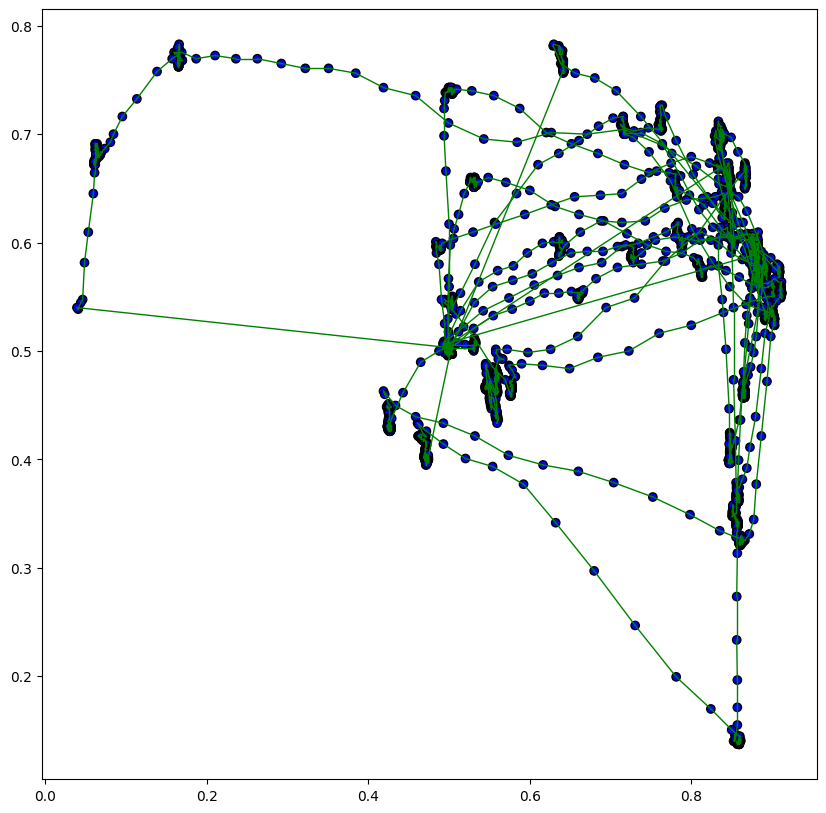

In [7]:
scanpath_visualization(get_object(data), x, y, with_axes=True, path_width=1)

### 1. Fixation Extraction

While squashing gazes, we would like to extract fixations and keep the path trajectory. Thus, the general approach is as follows: mark each gaze with $0$ (not a part of fixation) or $1$ (a part of fixation), then squash consecutive ones into single fixation.  Here we denote $n$ fixations as triplets $\{(x_i, y_i, t_i)\}_{i=1}^{n}$ - x coordinate, y coordinate, timestamp. `eyetracking.preprocessing.fixation_extraction` has three algorithms for fixations extraction:

1. IVT  - velocity threshold identification algorithm. Gazes that have velocity below threshold are considered to be fixations, since high velocities are attributes of saccades. If $a$ is an algorithm and $d$ some metric in $\mathbb{R}^2$, then for single fixation:

$$a(i) = \left[\frac{d((x_i, y_i), (x_{i + 1}, y_{i + 1}))}{t_{i + 1} - t_i} \leq T\right]$$

2. IDT  - dispersion threshold identification algorithm. This algorithm uses sliding window to find consecutive gazes with dispersion less than `max_dispersion` and duration more than `min_duration`. These heuristics ensure that extracted fixations have small variance and their duration is long enough.


3. IHMM - hidden Markov model identification algorithm. Algorithm finds a sequence of fixations that maximizes the log probability of observing given velocities of gazes under conditions of Hidden Markov Model. More formally, denote velocity of $i$-th gaze as $\displaystyle v_i = \frac{d((x_i, y_i), (x_{i + 1}, y_{i + 1}))}{t_{i + 1} - t_i}$ - this is observed process, while hidden process is sequence of zeros and ones $\{s_i\}_{i=1}^{n}$, as discussed previously, $1$ indicating fixation. We fix some prior distribution of velocities (normal is taken as empirical rule) and transition matrix, then, under assumption of Markov process, i.e. $P(s_i = b|v_{i - 1}, ..., v_1) = P(s_i = b|v_{i - 1}, ..., v_{i - k})$ for some $k \geq 1$, probability is maximized in greedy manner.

Let's use IDT since it is a common choice among eyetracking software products.

In [8]:
from eyetracking.preprocessing.fixation_extraction import IDT

IDT has two parameters: `min_duration` of fixation and `max_dispersion` of gazes within fixation. They provide a great control over the desired results.

In [9]:
preprocessor = IDT(x=x, y=y, t=t, pk=pk, min_duration=1e-5, max_dispersion=1e-3)

fixations = preprocessor.fit_transform(data)
fixations

,subject,film,gaze_x,gaze_y,start_time,end_time,distance_min,distance_max,dispersion,duration,saccade_duration,saccade_length,saccade_angle,saccade2_angle
0,V01,doves,0.502003,0.931320,3.249,1133.132,0.000000,0.001675,0.000781,1129.883,0.000,0.000000,0.000000,0.000000
1,V02,bridge_2,0.500647,0.501644,4.449,254.506,0.000000,0.002964,0.000781,250.057,0.000,0.000000,0.000000,0.000000
2,V02,bridge_2,0.402734,0.442963,290.371,294.465,0.001563,0.001675,0.000781,4.094,35.865,0.114150,210.934825,19.111463
3,V02,bridge_2,0.409743,0.451329,306.451,438.509,0.000000,0.003064,0.000781,132.058,11.986,0.010913,50.046288,48.033449
4,V02,bridge_2,0.203320,0.444074,502.479,514.339,0.000781,0.004444,0.000781,11.860,63.970,0.206550,182.012839,40.667033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6319,V11,street,0.884953,0.585911,1293.793,1689.775,0.000000,0.001675,0.000781,395.982,8.035,0.007695,222.514354,158.264124
6320,V11,street,0.881576,0.584630,1697.815,1885.798,0.000000,0.002773,0.000781,187.983,8.040,0.003613,200.778478,189.649606
6321,V11,street,0.809375,0.542222,1909.753,1913.711,0.001481,0.004513,0.000000,3.958,23.955,0.083734,210.428084,11.315721
6322,V11,street,0.816016,0.548148,1925.794,1929.769,0.000781,0.001675,0.000781,3.975,12.083,0.008900,41.743804,1.723784


Preprocessing algorithms compute a variety of features alongside with fixation extraction. For example, lengths and durations of saccades between fixations, as well as angles between succeeding and preceding saccades (`saccade2_angle`).

Now, let's see how the path of our object has changed:

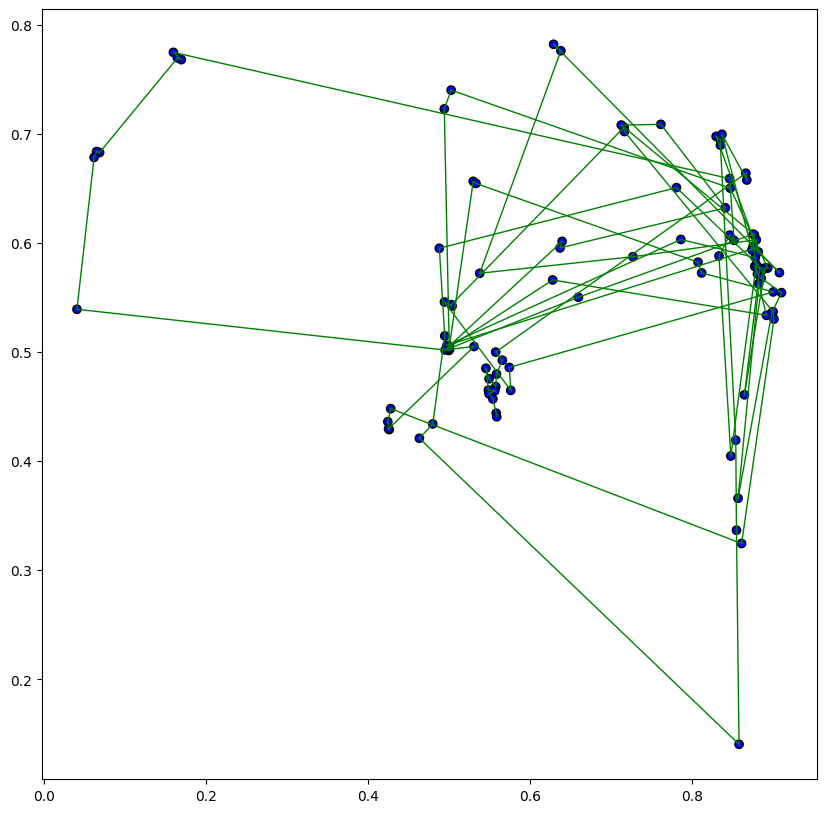

In [10]:
scanpath_visualization(get_object(fixations), x, y, with_axes=True, path_width=1)

### 2. Filtering gazes.

`eyetracking.preprocessing.smoothing` provides 4 filters to smooth gazes before the process of fixation extraction:
1. Savitzkiy-Golay filter - fits $k$-degree polynomial using $k$ last points in sequence using OLS.
2. FIR filter - weighted sum of $k$ previous values (convolution of signals).
3. IIR filter - similar to FIR filter but with two convolution signals.
4. Wiener filter. This filter assumes the following model of distortion:

$$g(x) = f(x) * h(x) + s(x)$$

where $f$ is true signal, $h$ is distortion signal, $*$ is convolution operation, $s$ is noise, and $g$ is distorted signal (observed signal). Wiener's approach considers input signal and noise as random variables and finds such estimator $\hat{f}$ which minimizes the variance of $\hat{f} - f$. It could be shown that in the underlined model the minimum is achieved (in frequency domain) at:

$$\hat{F}(x) = \frac{\overline{H(x)}}{|H(x)|^2 + K}G(x)$$

where
* $\hat{F}(x)$ - Fourier-image of $f$.
* $H(x)$ - Fourier-image of distorting function $h$.
* $\overline{\cdot}$ - complex inverse.
* $|\cdot|$ - complex modulus.
* $K$ - approximation constant.

Filters are often applied before fixation extraction. Let's do it using `sklearn`'s pipeline.

In [11]:
from eyetracking.preprocessing.smoothing import WienerFilter, SavGolFilter
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[
    ("wf_filter", WienerFilter(x=x, y=y, t=t, pk=pk, K='auto')),          # Wiener filter
    ("sg_filter", SavGolFilter(x=x, y=y, t=t, pk=pk, window_length=10)),  # Savitzkiy-Golay filter
    ("preprocessor", preprocessor)                                        # IDT algorithm
])

fixations_smooth = pipe.fit_transform(data)

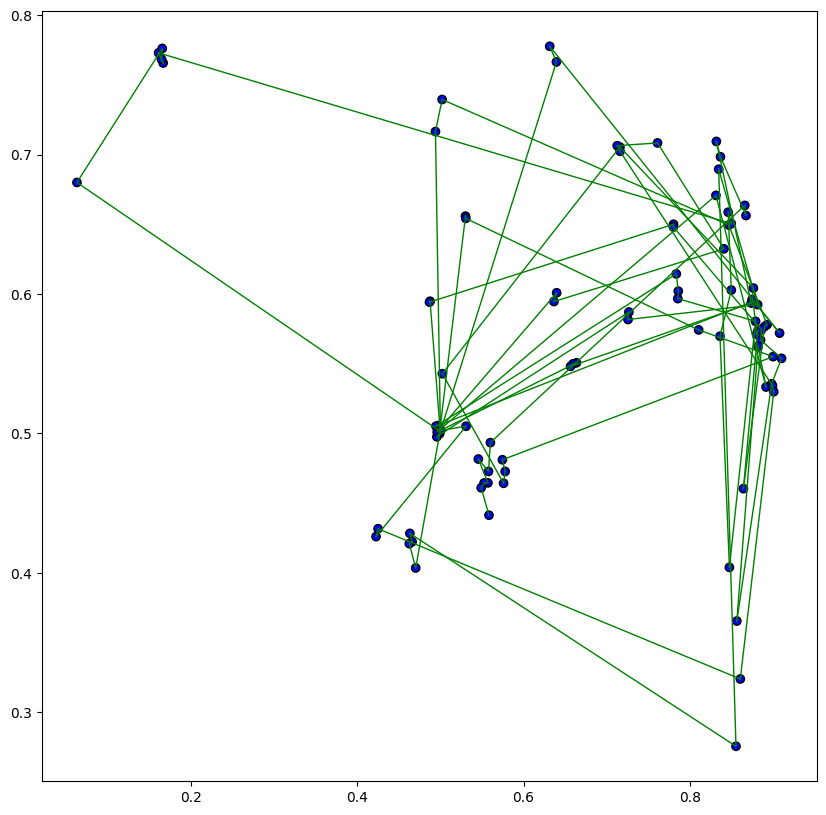

In [12]:
scanpath_visualization(get_object(fixations_smooth), x, y, with_axes=True, path_width=1)

Number of fixations without filtering:

In [13]:
len(get_object(fixations))

103

Number of fixations with filtering:

In [14]:
len(get_object(fixations_smooth))

94

### References

1. [Sample dataset](https://www.inb.uni-luebeck.de/index.php?id=515), static images.
2. Fixation extraction algorithms are taken from [Salvucci, Goldberg paper](https://www.researchgate.net/publication/220811146_Identifying_fixations_and_saccades_in_eye-tracking_protocols).
3. Savitzkiy-Golay, FIR, IIR classes are wrappers of `scipy.signal` methods.
4. About [Wiener filter](https://en.wikipedia.org/wiki/Wiener_filter) on Wikipedia.